In [1]:
from imports import *
from periodogram import compute_LSperiodogram
from read_data import *
from bgls import bgls
from rvmodel import get_rv1
from priors import *
from autocorrDFM import *
%matplotlib inline


Bad key "xtick.labeltop" on line 358 in
/Users/ryancloutier/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [13]:
# get data
bjd, rv, erv, fwhm, bis, Halpha, eHalpha, Hbeta, eHbeta, Hgamma, eHgamma, NaD, eNaD, Sindex, eSindex = read_HARPS()
#g =  [5 48 83] 3.69 days
#g = [] 7.45 days

-5678.16


## visualize data

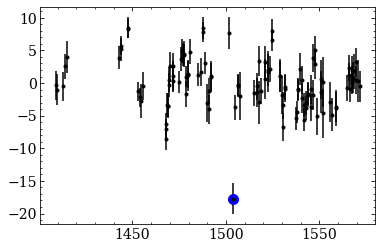

In [28]:
# plot RVs
t0 = 2457000
plt.errorbar(bjd-t0, rv, erv, fmt='k.')

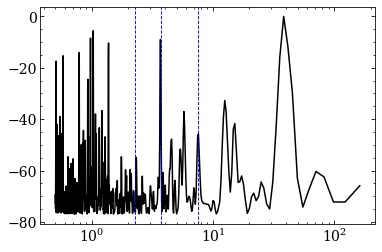

In [15]:
per,pwr = bgls(bjd, rv, erv, plow=.5, phigh=bjd.max()-bjd.min(), n_steps=1e3)
plt.plot(per, np.log(pwr), 'k-')
plt.xscale('log')
for p in Ps:
    plt.axvline(p, ls='--', lw=.9, color='b')

## run LOOCV on the remaining planet periods

In [16]:
def run_loocv(P, bjd, rv, erv, mu, kepmodel):
    '''Investigate the strength of a particular periodicity by omitting individual measurements.'''
    assert bjd.size == rv.size
    assert bjd.size == erv.size
    assert bjd.size == mu.size
    assert bjd.size == kepmodel.size
    
    prob_P = np.zeros(bjd.size)
    for i in range(bjd.size):
        # compute BGLS
        bjd_red = np.delete(bjd, i)
        rv_red = np.delete(rv-mu-kepmodel, i)
        erv_red = np.delete(erv, i)
        per,prob = bgls(bjd_red, rv_red, erv_red, plow=.5, phigh=2e2, n_steps=1e3)
        
        # what is the probability of the period of interest?
        g = np.isclose(per, P, rtol=.01)
        prob_P[i] = prob[g].max()
        
    return prob_P

In [23]:
# run loocv
Ps = [2.25,3.69,7.45]
P = Ps[1]
prob_P = run_loocv(P, bjd, rv, erv, np.zeros(bjd.size), np.zeros(bjd.size))

[ 5 48 83]
3.69


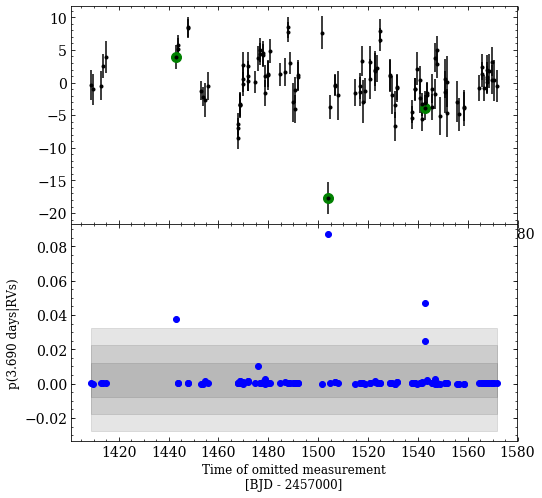

In [24]:
# plot loocv results
t0 = 2457000#bjd.min()
plt.figure(figsize=(8,8))
plt.subplot(211)
plt.errorbar(bjd-t0, rv, erv, fmt='k.')
b = (abs(prob_P-prob_P.mean()) > 3*prob_P.std())
print np.where(b)[0]
plt.plot(bjd[b]-t0, (rv)[b], 'go', ms=10)

plt.subplot(212)
plt.plot(bjd-t0, prob_P, 'o')
for i in range(1,4):
    plt.fill_between(bjd-t0, prob_P.mean()-i*prob_P.std(), prob_P.mean()+i*prob_P.std(), alpha=.1, color='k')
plt.xlabel('Time of omitted measurement\n[BJD - %i]'%t0, fontsize=12)
plt.ylabel('p(%.3f days|RVs)'%P, fontsize=12)
print P

plt.subplots_adjust(hspace=0)

In [25]:
pwr

array([2.35638931e-29, 4.13331848e-32, 4.34875086e-32, 7.49773222e-28,
       6.21343401e-27, 5.75694005e-30, 5.85219625e-33, 4.47168608e-28,
       1.30920761e-13, 8.77839863e-06, 9.95769310e-01, 1.26906770e-07,
       2.65404673e-19, 1.08138618e-28, 2.74666677e-33, 2.10217373e-32,
       9.52262285e-30, 1.04000617e-28, 3.66385284e-31, 7.23517415e-32,
       1.27709298e-30, 3.26675520e-31, 3.77855090e-33, 4.98357024e-34,
       8.37011760e-32, 4.46904580e-29, 1.06230506e-27, 1.16974131e-28,
       8.43543813e-29, 1.06055071e-23, 8.08542134e-19, 8.87887590e-20,
       4.02854409e-27, 2.04258302e-30, 6.90795938e-27, 1.23732232e-21,
       8.66729523e-17, 6.26520317e-15, 1.13533337e-17, 1.07206204e-22,
       1.49393169e-28, 4.95464082e-32, 5.74818004e-33, 8.64839933e-34,
       4.25801812e-34, 2.75758362e-33, 4.62002225e-32, 7.25873050e-32,
       4.43066469e-33, 1.26282307e-33, 3.51433479e-33, 1.12099346e-32,
       1.71190896e-32, 1.73808089e-32, 1.83538285e-32, 2.21418192e-32,
      

## plot periodograms

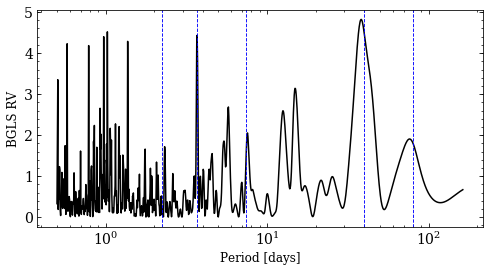

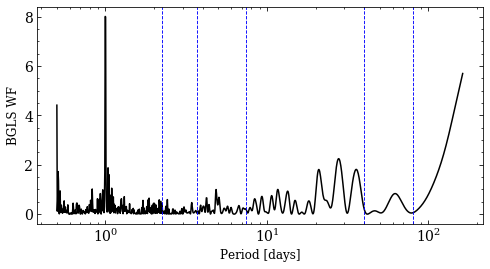

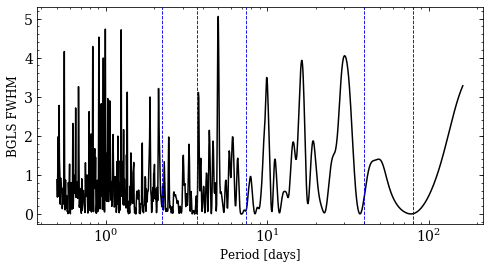

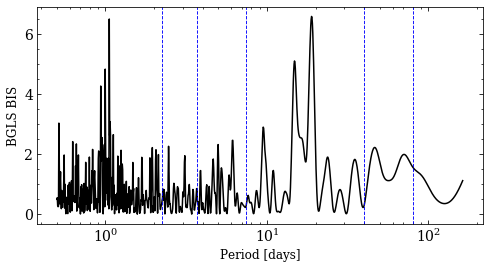

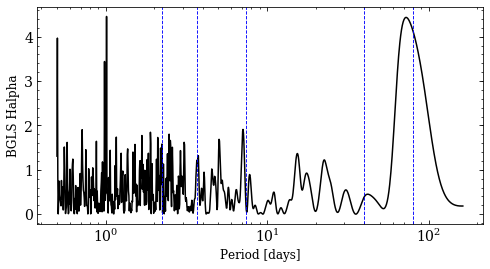

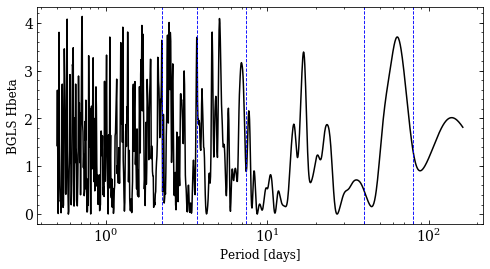

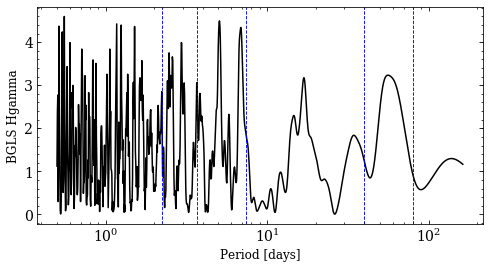

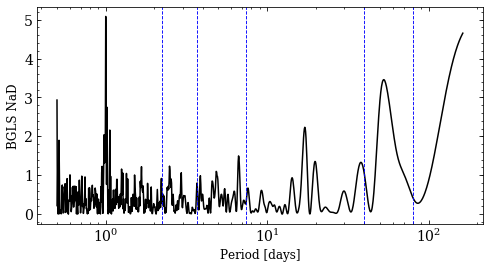

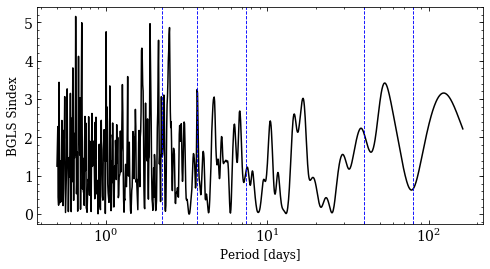

In [4]:
# plot periograms
Prot = 80
Ps = [2.25,3.69,7.45,Prot,Prot/2.]
xs = [bjd, bjd, bjd, bjd, bjd, bjd, bjd, bjd, bjd]
ys = [rv, bjd, fwhm, bis, Halpha, Hbeta, Hgamma, NaD, Sindex]
eys = [erv, erv, np.ones(bjd.size), np.ones(bjd.size), eHalpha, eHbeta, eHgamma, eNaD, eSindex]
labels = ['RV','WF','FWHM','BIS','Halpha','Hbeta','Hgamma','NaD','Sindex']
for i in range(len(xs)):
    #per,pwr = bgls(xs[i], ys[i], eys[i], plow=.5, phigh=bjd.max()-bjd.min(), n_steps=1e3)
    per,_,pwr = compute_LSperiodogram(xs[i], ys[i], eys[i], plims=(.5,bjd.max()-bjd.min()))
    plt.figure(i, figsize=(8,4))
    plt.plot(per, pwr, 'k-'), plt.xscale('log')
    plt.ylabel('BGLS %s'%labels[i], fontsize=12), plt.xlabel('Period [days]', fontsize=12)
    for p in Ps:
        plt.axvline(p, ls='--', lw=.9, color='b')